In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

from keras.models import Sequential
from keras.layers import Dense, LSTM

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##数据准备

In [ ]:
stock_list_path = '/content/drive/MyDrive/MSBD5001-Final/selected_30_stocks.csv'
name_list = pd.read_csv(stock_list_path)
name_list = name_list['stock'].tolist()

In [ ]:
os.listdir('/content/drive/MyDrive/MSBD5001-Final/pred_res/')

['DRI.csv',
 'ADI (1).csv',
 'ZION.csv',
 'TJX.csv',
 'PYPL.csv',
 'MO.csv',
 'MCHP.csv',
 'LVS.csv',
 'INTU.csv',
 'KMX.csv',
 'HIG.csv',
 'GPN.csv',
 'DVA.csv',
 'AES.csv',
 'SRE.csv',
 'TSCO.csv',
 'WELL.csv',
 'NEM.csv',
 'GM.csv',
 'REG.csv',
 'K.csv',
 'VTRS.csv',
 'ADI.csv',
 'BXP.csv',
 'UHS.csv',
 'JCI.csv',
 'AKAM.csv',
 'IEX.csv',
 'ANSS.csv',
 'V.csv',
 'LUV.csv']

In [ ]:
# 改成你放代码的路径
ROOT_PATH = '/content/drive/MyDrive/MSBD5001-Final/sp500'
RES_PATH ='/content/drive/MyDrive/MSBD5001-Final/pred_res/'
os.chdir(ROOT_PATH)
os.listdir(ROOT_PATH)

# 读取sp500folder中存在的所有文件夹
dirs = os.listdir()
def each_df(name_list):
  for stock in name_list:
    # read data
    path = os.path.join(ROOT_PATH, stock)
    files = os.listdir(path)
    
    if stock+'_OHLC_1d.csv' not in files or stock+'_info.csv' not in files:
      # 如果没有OHLC文件，说明股票不存在，跳过
      continue
    res_files=os.listdir(RES_PATH)
    if stock+'.csv' in res_files:
      print('-----------skip {}----------'.format(stock))
      continue
    df = pd.read_csv(path+'/'+stock+'_OHLC_1wk.csv')
    info = pd.read_csv(path+'/'+stock+'_info.csv')  # info

    # drop rows with 'NAN' in month data
    df = df.dropna(axis=0,how='any')
    # df = df.drop(columns=['Date'])
    # df['Stock'] = stock
    df.reset_index(drop=True,inplace=True)
    yield df,stock




##进行预测

In [ ]:
for stock_df,name in each_df(name_list):
  test = stock_df
  break


In [ ]:
len(res)

39

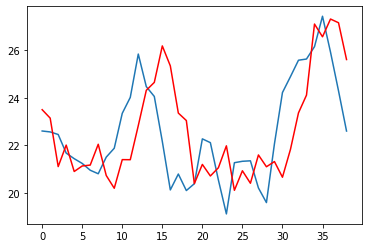

In [ ]:
import matplotlib.pyplot as plt

plt.plot(test['Close'][-39:].reset_index(drop=True))
plt.plot(res,color='red')
plt.show()

In [ ]:
test.tail(40)

In [ ]:
end

260

In [ ]:
def get_window_df(test):  
  end = test[test['Date']=='2021-12-26 00:00:00-05:00'].index[0]
  # test[:end]
  n = test.shape[0] - end +1
  for i in range(n):
    temp = test[:end+i]
    yield temp

# for stock_df,stock_name in each_df(name_list):
#   test,name = stock_df,stock_name
#   break
# get train中的60就是观测的长度
def get_train(steps,train_data):
    x_train = []
    y_train = []

    for i in range(60, len(train_data)-steps+1):
        x_train.append(train_data[i-60:i])
        y_train.append(train_data[i+steps-1])
        if i<= 61:
            # print(x_train)
            # print(y_train)
            # print()
            pass

    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
    return x_train, y_train

def model_factory(x_train,y_train):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def predict_one(stock_df,name):
  end = stock_df[stock_df['Date']=='2021-12-26 00:00:00-05:00'].index[0]
  stock_df = stock_df.drop(columns=['Date'])
  dataset = stock_df.values
  n = stock_df.shape[0]-end 

  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(dataset)

  res = []
  print('----------------------------'+name+'-------------------------------')
  # Create the training data set 
  # Create the scaled training data set
  for i in range(n):
    if i+end+1==stock_df.shape[0]:
      print("---end----")
      break
    print('---------------------------------windows:{}----------------------------'.format(i+1))
    train_data = scaled_data[0:end+i, :]

    # x_train_1 means train data for step ==1
    x_train_1,y_train_1 = get_train(1,train_data)



    # Train
    # Build the LSTM model


    model_1 = model_factory(x_train_1,y_train_1)

    # Train the model
    model_1.fit(x_train_1, y_train_1, batch_size=5, epochs=15)

    # test
    x_test = []
    x_test.append(scaled_data[end+i+1-60:end+i+1, :])
        
    # Convert the data to a numpy array
    x_test_np = np.array(x_test)
    predictions = model_1.predict(x_test_np)
    predictions = scaler.inverse_transform(predictions)
    res.append(predictions[0][0])

  res_df = pd.DataFrame(res)
  res_df.to_csv('/content/drive/MyDrive/MSBD5001-Final/pred_res/'+name+'.csv')

In [ ]:
for stock_df,name in each_df(name_list):
  predict_one(stock_df,name)
  # print(stock_df,name)
  





-----------skip AES----------
-----------skip DRI----------
-----------skip LVS----------
-----------skip ZION----------
-----------skip TJX----------
-----------skip KMX----------
-----------skip DVA----------
-----------skip PYPL----------
-----------skip INTU----------
----------------------------ADI-------------------------------
---------------------------------windows:1----------------------------
Epoch 1/15
40/40 [==============================] - 8s 10ms/step - loss: 0.0227
Epoch 2/15
40/40 [==============================] - 0s 8ms/step - loss: 0.0057
Epoch 3/15
40/40 [==============================] - 0s 8ms/step - loss: 0.0053
Epoch 4/15
40/40 [==============================] - 0s 7ms/step - loss: 0.0050
Epoch 5/15
40/40 [==============================] - 0s 7ms/step - loss: 0.0052
Epoch 6/15
40/40 [==============================] - 0s 7ms/step - loss: 0.0047
Epoch 7/15
40/40 [==============================] - 0s 7ms/step - loss: 0.0043
Epoch 8/15
40/40 [=====================

1/1 [==============================] - 1s 638ms/step
---------------------------------windows:6----------------------------
Epoch 1/15
41/41 [==============================] - 2s 9ms/step - loss: 0.0261
Epoch 2/15
41/41 [==============================] - 0s 7ms/step - loss: 0.0063
Epoch 3/15
41/41 [==============================] - 0s 7ms/step - loss: 0.0059
Epoch 4/15
41/41 [==============================] - 0s 7ms/step - loss: 0.0056
Epoch 5/15
41/41 [==============================] - 0s 7ms/step - loss: 0.0051
Epoch 6/15
41/41 [==============================] - 0s 7ms/step - loss: 0.0050
Epoch 7/15
41/41 [==============================] - 0s 7ms/step - loss: 0.0049
Epoch 8/15
41/41 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 9/15
41/41 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 10/15
41/41 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 11/15
41/41 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch

流式输出内容被截断，只能显示最后 5000 行内容。
----------------------------IEX-------------------------------
---------------------------------windows:1----------------------------
Epoch 1/15
40/40 [==============================] - 2s 10ms/step - loss: 0.0266
Epoch 2/15
40/40 [==============================] - 0s 9ms/step - loss: 0.0057
Epoch 3/15
40/40 [==============================] - 0s 9ms/step - loss: 0.0054
Epoch 4/15
40/40 [==============================] - 0s 9ms/step - loss: 0.0045
Epoch 5/15
40/40 [==============================] - 0s 9ms/step - loss: 0.0052
Epoch 6/15
40/40 [==============================] - 0s 9ms/step - loss: 0.0048
Epoch 7/15
40/40 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 8/15
40/40 [==============================] - 0s 9ms/step - loss: 0.0043
Epoch 9/15
40/40 [==============================] - 0s 11ms/step - loss: 0.0041
Epoch 10/15
40/40 [==============================] - 0s 11ms/step - loss: 0.0041
Epoch 11/15
40/40 [==========================